In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import imageio
from torchvision.utils import save_image
import scipy.misc


In [2]:
height = 650 #500 landscape  # 650 portrait
width = 500 #650 landscape #500 portrait
alpha = 1 #also known as content weight
beta = 1e3 #within 1e3 - 1e6 also known as style weight
epochs = 36

In [3]:
loader = transforms.Compose([
            transforms.Resize((height, width)),
            transforms.ToTensor()
        ])

unloader = transforms.ToPILImage()

In [ ]:
styleLoader = transforms.Compose([
            transforms.ToTensor()
        ])

def loadStyleImage(name):
    image = Image.open(name)
    original_size = image.size  # use the original size
    image = Variable(loader(image))
    image = image.unsqueeze(0)
    return image, original_size

In [4]:
def loadImage(name):
    image = Image.open(name)
    image = Variable(loader(image))
    image = image.unsqueeze(0)
    return image

def saveImage(input, path):
    image = input.data.clone().cpu()
    batch_size = image.size(0)
    image = image.view(batch_size, 3, height, width)
    image = unloader(image)
    scipy.misc.imsave(path, image)
    
def im_convert(tensor):
    ''' Presentar imagen como Tensor'''
    imagen = tensor.to('cpu').clone().detach()
    imagen = imagen.numpy().squeeze()
    imagen = imagen.transpose(1, 2, 0)
    #imagen = imagen * np.array((0.029, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    imagen = imagen.clip(0, 1)
    
    return imagen

def showImages(content, style, output):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

    ax1.imshow(im_convert(content))
    ax1.axis('off')
    ax1.set_title('Original Picture')

    ax2.imshow(im_convert(style))
    ax2.axis('off')
    ax2.set_title('Style Image')

    ax3.imshow(im_convert(output) )
    ax3.axis('off')
    ax3.set_title('Merged Image')

    plt.show()

def save_images(input, paths, imsize):
    assert len(input) == len(paths), "Number of inputs and paths should be the same."
    N = input.size()[0]
    images = input.data.clone().cpu()
    for n in range(N):
        image = images[n]
        image = image.view(3, imsize, imsize)
        image = unloader(image)
        imageio.imwrite(paths[n], image)


In [5]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a,b,c,d = input.size()
        features = input.view(a*b, c*d)
        G = torch.mm(features, features.t())
        return G.div(a*b*c*d)

In [6]:
class CNN(object):
    def __init__(self, style, content, pastiche, alpha, beta, lr=0.01):
        super(CNN, self).__init__()
        
        self.style = style
        self.content = content
        self.pastiche = nn.Parameter(pastiche.data)

        self.content_layers = ['conv_4']
        self.style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
        self.contentWeight = alpha
        self.styleWeight = beta
        self.total_loss = None

        self.loss_network = models.vgg19(weights='IMAGENET1K_V1')

        self.gram = GramMatrix()
        self.loss = nn.MSELoss()
        self.optimizerLBFGS = optim.LBFGS([self.pastiche])
        self.optimizerAdam = optim.Adam([self.pastiche], lr=lr)

        self.use_cuda = torch.cuda.is_available()
        if self.use_cuda:
            print('Using GPU device')
            self.loss_network.cuda()
            self.gram.cuda()
        else:
            print('Using CPU device')
            self.loss_network.cpu()
            self.gram.cpu()

    def trainLBFGS(self):
        def closure():
            self.optimizerLBFGS.zero_grad()

            pastiche = self.pastiche.clone()
            pastiche.data.clamp_(0,1)
            content = self.content.clone()
            style = self.style.clone()

            content_loss = 0
            style_loss = 0

            i = 1
            not_inplace = lambda layer: nn.ReLU(inplace=False) if isinstance(layer, nn.ReLU) else layer
            for layer in list(self.loss_network.features):
                layer = not_inplace(layer)
                if self.use_cuda:
                    layer.cuda()
                else:
                    layer.cpu()
                
                pastiche, content, style = layer.forward(pastiche), layer.forward(content), layer.forward(style)

                if isinstance(layer, nn.Conv2d):
                    name = "conv_" +str(i)

                    if name in self.content_layers:
                        content_loss += self.loss(pastiche * self.contentWeight, content.detach() * self.contentWeight)

                    if name in self.style_layers:
                        pastiche_g, style_g = self.gram.forward(pastiche), self.gram.forward(style)
                        style_loss += self.loss(pastiche_g * self.styleWeight, style_g.detach() * self.styleWeight)
                    
                if isinstance(layer, nn.ReLU):
                    i += 1
            
            total_loss = content_loss + style_loss
            self.total_loss = total_loss
            total_loss.backward()

            return total_loss
    
        self.optimizerLBFGS.step(closure)
        return self.pastiche
    
    
    def trainAdam(self, steps):
        for i in range(steps):
            self.optimizerAdam.zero_grad()

            pastiche = self.pastiche.clone()
            pastiche.data.clamp_(0, 1)
            content = self.content.clone()
            style = self.style.clone()

            content_loss = 0
            style_loss = 0

            i = 1
            not_inplace = lambda layer: nn.ReLU(inplace=False) if isinstance(layer, nn.ReLU) else layer
            for layer in list(self.loss_network.features):
                layer = not_inplace(layer)
                if self.use_cuda:
                    layer.cuda()
                else:
                    layer.cpu()

                pastiche, content, style = layer.forward(pastiche), layer.forward(content), layer.forward(style)

                if isinstance(layer, nn.Conv2d):
                    name = "conv_" + str(i)

                    if name in self.content_layers:
                        content_loss += self.loss(pastiche * self.contentWeight, content.detach() * self.contentWeight)

                    if name in self.style_layers:
                        pastiche_g, style_g = self.gram.forward(pastiche), self.gram.forward(style)
                        style_loss += self.loss(pastiche_g * self.styleWeight, style_g.detach() * self.styleWeight)

                    if isinstance(layer, nn.ReLU):
                        i += 1

            total_loss = content_loss + style_loss
            self.total_loss = total_loss
            total_loss.backward()

            self.optimizerAdam.step()
        return self.pastiche

In [7]:
device = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [8]:
stylePath = '../data/style/treeOfLife.jpg'
style = loadImage(stylePath)
contentPath = '../data/content/brown.jpg'
content = loadImage(contentPath)

#pastiche = loadImage('../data/content/nalselfie.jpg').type(dtype)
pastiche = content.clone()

# This is to make random noise image (randomize pixels)
#pastiche.data = torch.randn(pastiche.data.size()).type(dtype)

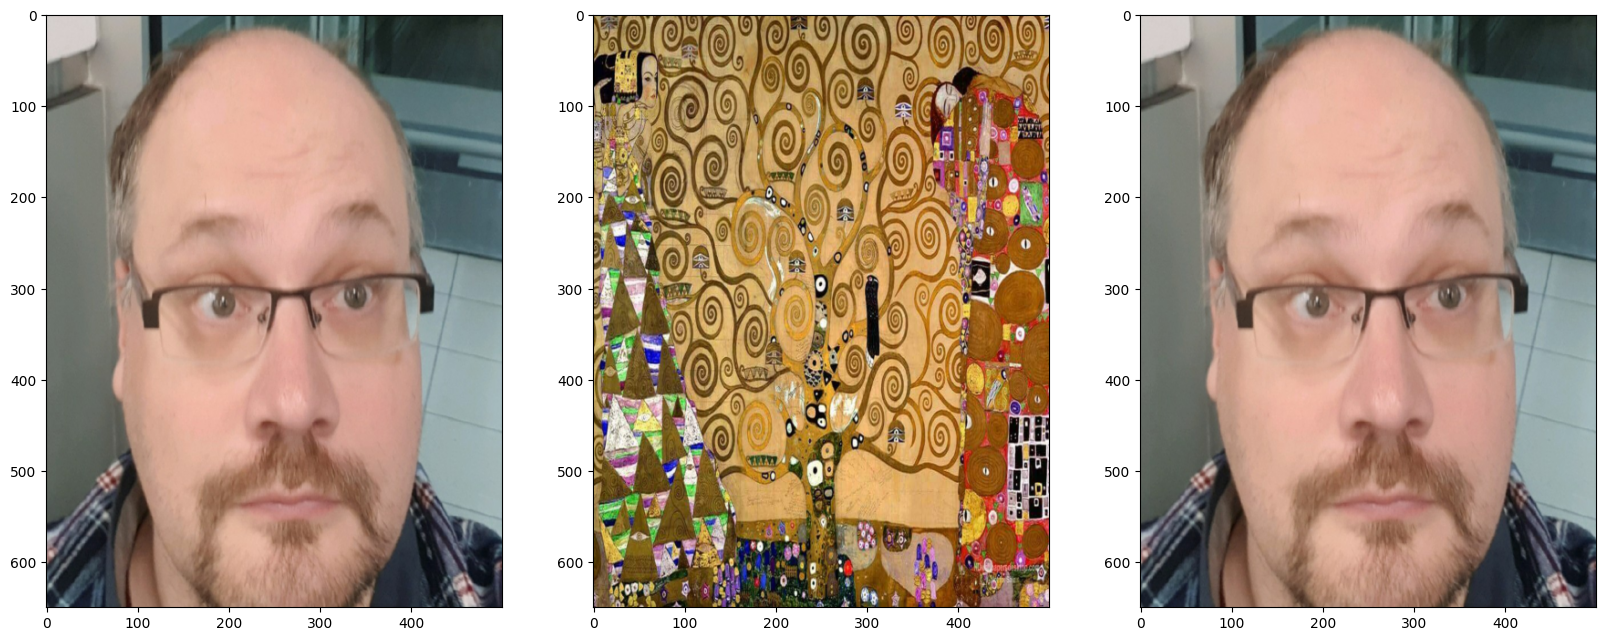

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize = (20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
ax3.imshow(im_convert(pastiche))

Using CPU device
Epoch: 0
Total Loss computed so far:  tensor(20.1138, grad_fn=<AddBackward0>)


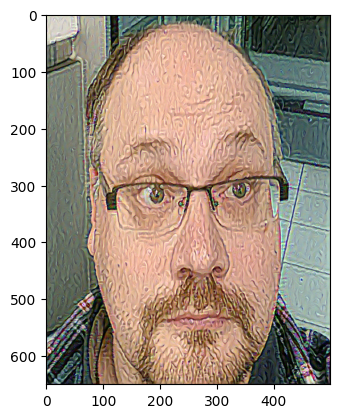

Epoch: 5
Total Loss computed so far:  tensor(5.6405, grad_fn=<AddBackward0>)


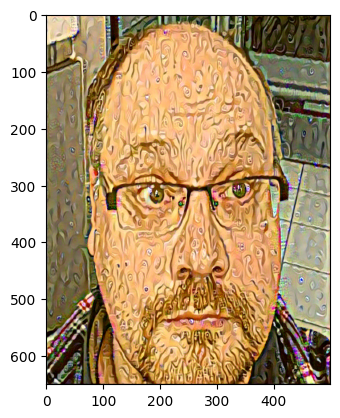

Epoch: 10
Total Loss computed so far:  tensor(5.0678, grad_fn=<AddBackward0>)


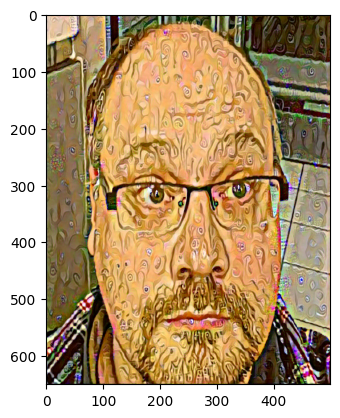

In [10]:
canva = content.clone()
cnn = CNN(style, content, canva, alpha, beta)

content_parts = contentPath.split('../data/content/')
style_parts = stylePath.split('../data/style/')
content_id = content_parts[len(content_parts)-1].split('.jpg')[0]
style_id = style_parts[len(style_parts)-1].split('.jpg')[0]
path = f"../data/out/{content_id}_{style_id}_{epochs}.png"

for i in range(epochs+1):
    canva = cnn.trainLBFGS()

    if i % 5 == 0:
        print("Epoch: %d" % (i))
        
        canva.data.clamp_(0 ,1) #normalizes tensor (any value less than 0 will be 0 and more than 1 will be 1)
        print("Total Loss computed so far: ", cnn.total_loss)
        plt.imshow(im_convert(canva))
        plt.show()
        
save_image(canva, path)

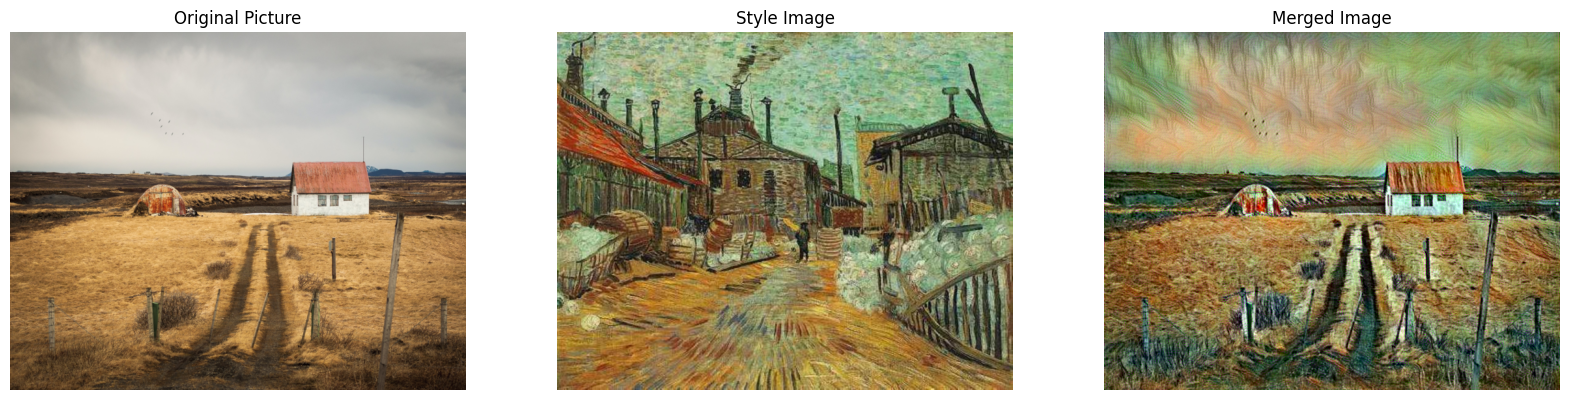

In [ ]:
showImages(content,style,canva)